In [4]:
import pandas as pd
from ftplib import FTP
import os

#read in supplementary table
drugInfo = pd.read_csv("Drug_Info_Supp_Table.csv")
drugInfo["Drug"] = drugInfo["Drug"].str.strip()

#group all drugs by their type and turn into dictionary
drugTypes = drugInfo.groupby("Type")["Drug"].apply(list).to_dict()
#print(drugTypes)

# get ordered list of drugs arranged by drug type
orderedDrugsList = []
type_boundaries = []
for type, drugs in drugTypes.items():
    for drug in drugs:
        orderedDrugsList.append(drug)
    type_boundaries.append(len(orderedDrugsList))

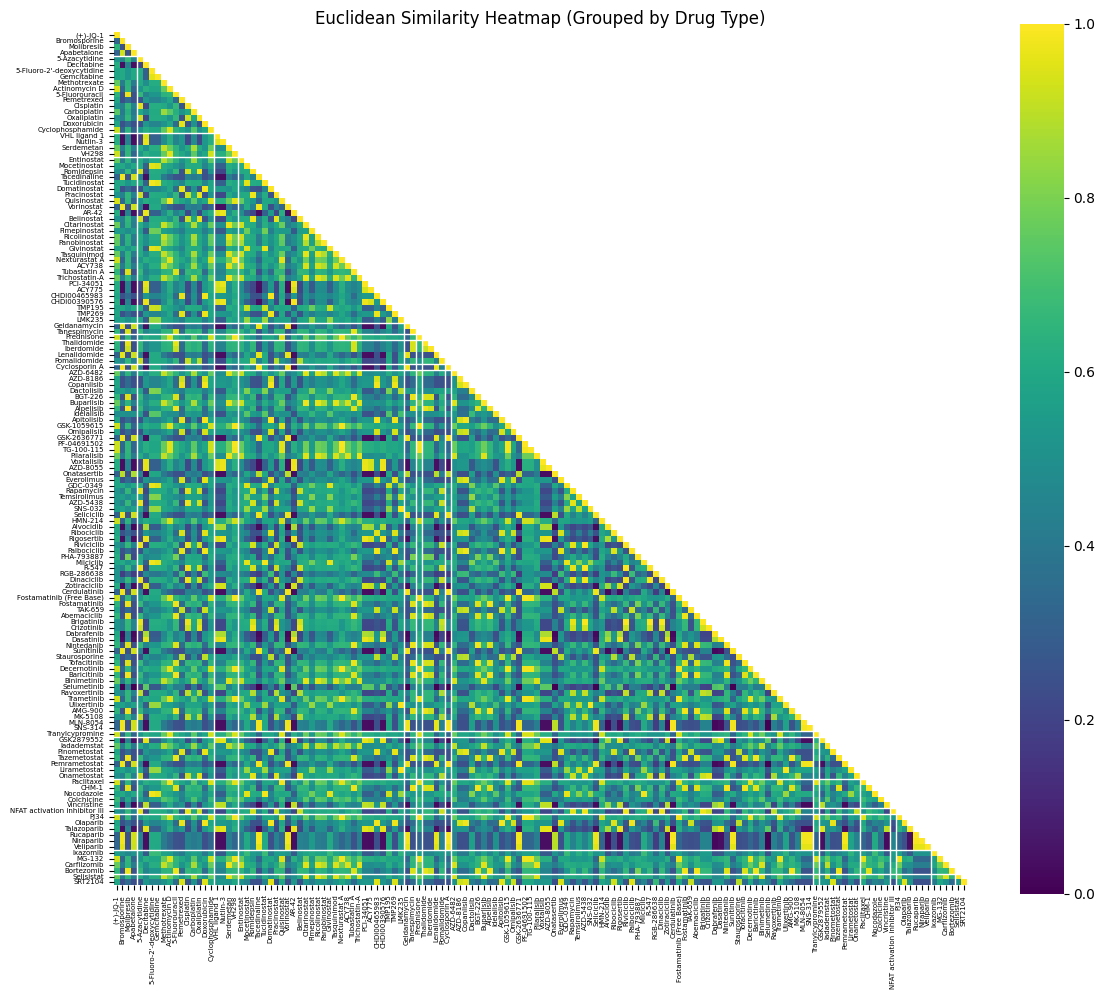

In [ ]:
# create EUCLIDEAN similarity matrix for mean intensity
import numpy
import sklearn 
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt


# load matrix and fill in empty vals with 0 
meanIntensityMatrix = pd.read_csv("Mean_Intensity_Matrix_All_Drugs.csv", index_col = 0).fillna(0)
# make column names just the drug name (remove _Mean_Intensity suffix!)
meanIntensityMatrix.columns = meanIntensityMatrix.columns.str.removesuffix("_Mean_Intensity")

# transpose data so drugs become rows instead of columns
transposedData = meanIntensityMatrix.transpose()
# save drug names index column for after
drugNames = transposedData.index

# plug transposed data into euclidean_distances function
eucDistanceMatrix = euclidean_distances(transposedData)
# convert to a dataframe and make row and column labels be the drug names
eucDistanceMatrix = pd.DataFrame(eucDistanceMatrix, columns = drugNames, index = drugNames)
# eucDistanceMatrix.to_csv("Euc_Distance_Matrix.csv")

# normalize euclidean distances and convert to similarity instead of distance (inverse)
minDistance = eucDistanceMatrix.min().min()
maxDistance = eucDistanceMatrix.max().max()

normalizedEucDistances = (eucDistanceMatrix - minDistance) / (maxDistance - minDistance)
eucSimilarityMatrix = 1 - normalizedEucDistances

reorderedEucMatrix = eucSimilarityMatrix.loc[orderedDrugsList, orderedDrugsList]
upperMask = numpy.triu(numpy.ones_like(reorderedEucMatrix, dtype=bool), k=1)

# plot heatmap with boundary lines
plt.figure(figsize=(12, 10))
sns.heatmap(reorderedEucMatrix, cmap='viridis', square=True, xticklabels=True, yticklabels=True, mask = upperMask)

# draw grid lines at group boundaries
for boundary in type_boundaries[:-1]:  # skip the last boundary (not needed)
    plt.axhline(boundary, color='white', linewidth=1)
    plt.axvline(boundary, color='white', linewidth=1)

plt.title("Euclidean Similarity Heatmap (Grouped by Drug Type)")
plt.xticks(rotation=90, fontsize = 5)
plt.yticks(rotation=0, fontsize = 5)
plt.tight_layout()
plt.show()


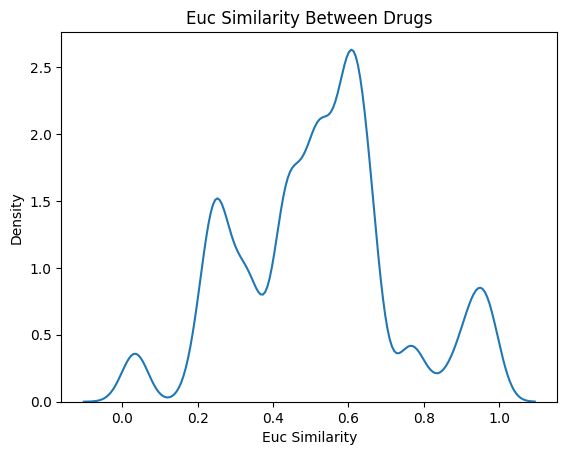

In [7]:
# plot overall euc distribution for intensity 

eucArray = eucSimilarityMatrix.to_numpy()
# get the indices of the lower triangle in the array
bottomDiagIndices = numpy.tril_indices_from(eucArray, k = -1)
# use indices to get values of the lower triangle in the array
bottomDiagVals = eucArray[bottomDiagIndices]

# plot the distribution
sns.kdeplot(bottomDiagVals)
plt.xlabel("Euc Similarity")
plt.title("Euc Similarity Between Drugs")
plt.show()

In [ ]:
# plot distributions for each drug subtype 
for type, drugNames in drugTypes.items():
    print(f"Type: {type}\nDrugs:\n\t{drugNames}")

    # get the sub-matrix of drugs for this type 
    subTypeMatrix = eucSimilarityMatrix.loc[drugNames, drugNames]
    # convert submatrix to a numpy array
    subArray = subTypeMatrix.to_numpy()
    # get indices of the lower triangle
    subBottomIndices = numpy.tril_indices_from(subArray, k = -1)
    # use indices to get values of the lower triangle
    subBottomVals = subArray[subBottomIndices]

    # plot the distribution
    sns.kdeplot(subBottomVals)
    plt.xlabel("Euclidean Similarity")
    plt.title(f"Euclidean Similarity Between {type}s")
    plt.show()

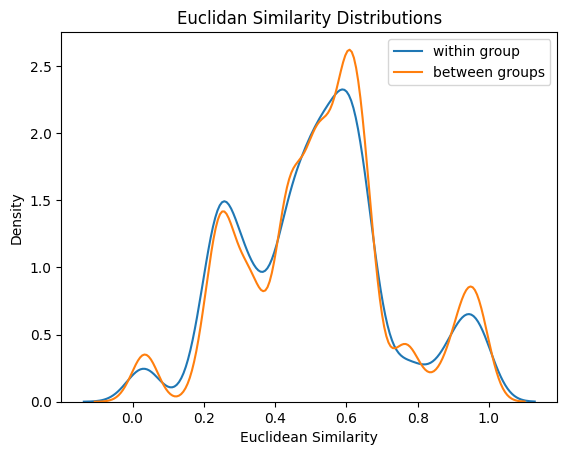

In [13]:
# compare within-group vs between-group similarities

# make one list of all the similarity values for pairs where both drugs are within the same group
withinGroupPairs = []
# make another list of all the similarity values for pairs where the two drugs are in different groups
btwGroupPairs = []
# make new dict with drugs as keys and types as values 
drugsToTypesDict = {}
for type, drugs in drugTypes.items():
    for drug in drugs:
        drugsToTypesDict[drug] = type

# nested for loop
# go through the list of drugs (orderedDrugsList)
for index, drug1 in enumerate(orderedDrugsList):
    # save curr drug (row) type in a var
    drug1Type = drugsToTypesDict[f"{drug1}"]
    # go through the list of drugs again but always starting at i (out loop drug) + 1 
    for drug2Index in range(index+1, len(orderedDrugsList)):
        drug2 = orderedDrugsList[drug2Index]
        # save curr drug (col) type in a var
        drug2Type = drugsToTypesDict[f"{drug2}"]
        # save curr similarity value in a var
        similarity = eucSimilarityMatrix.loc[drug1, drug2]
        # if drug 1 type (row) and drug 2 type (col) are the same
        if drug1Type == drug2Type:
            # add value of that pair's comparison (curr loc in the similarity matrix) to withinGroupPairs
            withinGroupPairs.append(similarity)
        else:
            # add value of that pair's comparison (curr loc in the similarity matrix) to btwGroupPairs
            btwGroupPairs.append(similarity)

# plot the distributions of within-group similarities and between-group similarities and compare them
sns.kdeplot(withinGroupPairs, label = "within group")
sns.kdeplot(btwGroupPairs, label = "between groups")
plt.xlabel("Euclidean Similarity")
plt.title("Euclidan Similarity Distributions")
plt.legend()
plt.show()